In [177]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit
import random as rd
import math 
import matplotlib.pyplot as plt
from qiskit import algorithms
from qiskit.circuit import Parameter
from qiskit.opflow import X,Y,Z,I,CX,CZ
SPSA = algorithms.optimizers.SPSA #choix de l'optimiseur avant la routine VQE 
from qiskit import Aer
from qiskit.algorithms import eval_observables
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import CRXGate
from qiskit.opflow.primitive_ops import PrimitiveOp
from qiskit.opflow import CircuitStateFn
from qiskit.algorithms import VQE
from qiskit.opflow import commutator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SLSQP
seed = 50
slsqp = SLSQP(maxiter=1000)
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

N = 4

In [183]:
def ansatz(N): 
    qc = QuantumCircuit(N)
    for k in range(N):
        thet = rd.random()*2*math.pi
        qc.rx(thet,k)
    return(qc)

def measure_energy(qc, operator): 
    psi = CircuitStateFn(qc)
    return(psi.adjoint().compose(operator).compose(psi).eval().real)

def trans(gate, n, i):
    #Envoie le "gate" de OperatorBase sur le qbit i, dont n est le nb total
    k = gate.num_qubits
    return(I.tensorpower(max(n-i-k, 0)) ^ gate ^ I.tensorpower(i))
# notre pool d'opérateurs est initialisé selon la méthode suivante 

OPS = []    
for k in range(N): 
    OPS.append( [True,k])
for k in range(N-1): 
    for j in range(N-1):
        if j != k:
            OPS.append([False,[k,j]])
    OPS.append([False, [k, N-1]])

def L_ops():
    #select operators from pool
    n = 2
    L_c = []
    OPS1 = OPS.copy()
    for k in range(n):
        j = int(rd.random()*len(OPS1))
        L_c.append(OPS1[j])
        del OPS1[j]
    return(L_c)
    
def perm(k):
    "ici k est une liste de deux entiers distincts compris entre 0 et N-1"
    res = [i for i in range(N)] #on créée l'ordre identité
    
    p0 = k[0]
    p1 = k[1]
    res[p1], res[p0 + 1] = p0 + 1, p1
    return(res)


noms_p = []
for k in range(10000):
    noms_p += [Parameter('theta_'+str(k))]


In [184]:
#définition de l'hamiltonien


J = 1
h = 0.5

"Hamiltonien pour 2 qbits:"

H = - J * CX.compose(Z.compose(CX)) - h * (X ^ I)

#Définition de l'hamiltonien du système
def hi(N, i):
    #n = nombre de qubits
    #i = indice
    if i >= N-1:
        return('Error Hi: The number of qubits is too small')
    H = (- J * CX.compose(Z.compose(CX))) - (h * (X ^ I))
    if i != 0:
        H = I.tensorpower(i) ^ H
    if i + 1 == N-1:
        return(H)
    else:
        H = H ^ I.tensorpower(N-i-2)
    return(H)


hamil = hi(N, 0)
for i in range(1, N-1):
    hamil += hi(N, i)


In [185]:
def gradient(ansatz, hamil):
    
    list = []
    
    L_c = L_ops()
    
    for k in L_c : 
        
        if k[0] : 
            
            operator = trans(Y,N,k[1])
            
            Com = commutator(hamil,operator)
            
            vqe = VQE(Ansatz, optimizer=slsqp, quantum_instance=qi)
            
            f = vqe.get_energy_evaluation(operator= PrimitiveOp(Operator(Com)))
            
            Avg = f(parameters)
            
            list.append([k,Avg])
        
        else : 
            
            operator = trans(CX, N, k[1][0]).permute(perm(k[1])).compose(trans(Z,N,k[1][0])).compose(trans(CX, N, k[1][0]).permute(perm(k[1])))
            
            Com = commutator(hamil,operator)
            
            vqe = VQE(Ansatz, optimizer=slsqp, quantum_instance=qi)
            
            f = vqe.get_energy_evaluation(operator= PrimitiveOp(Operator(Com)))
            
            Avg = f(parameters)
            
            list.append([k,Avg])
            
    return(list)

def Next_op(L_grad, eps): 
    imax = 0
    
    end = False 
    G = 0 
    for i in range(0,len(L_grad)):
        grad = L_grad[i][1]
        print(grad)
        G+= grad ** 2 #norme du vecteur gradient
        if abs(grad) > abs(L_grad[imax][1]) : #gradient maximal
            imax = i

    print("Gradient : " + str(math.sqrt(G)))
    if math.sqrt(G) < eps : 
        
        end = True 
    
    return(end,L_grad[imax])

def grow_ansatz(Ansatz, operator, parameters):
    
    n = len(parameters)
    
    #parameters+=[noms_p[n]]
    
    k = operator
    
    if k[0]:
        
        Ansatz.rx(noms_p[n],k[1])
        
    else: 
        Ansatz.cx(k[1][0], k[1][1])
        
        Ansatz.rz(noms_p[n],k[1][0])
        
        Ansatz.cx(k[1][0], k[1][1])
        
    return(Ansatz)


def Vqe(Ansatz,Hamil): 
    seed = 50
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
    slsqp = SLSQP(maxiter=1000)
    vqe = VQE(qc, optimizer=slsqp, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator= PrimitiveOp(Operator(hamil)))
    print(result)
    optimizer_evals = result.optimizer_evals
    return(result.optimal_parameters)
        

1.0938838205693733
2.3425510241328347
Gradient : 2.5853678874715764
energie :(-2.024719691307291+0j)
4.4468597439765265
4.4468597439765265
Gradient : 6.288809359902553
energie :(-2.024719407419144+0j)
0.002234552708056545
4.049438814892577
Gradient : 4.04943943142559
energie :(-2.122457662271241+0j)
0.002355397663530916
4.389310598399452
Gradient : 4.389311230377713
energie :(-2.1224580155839003+0j)
-1.3031107986617758
4.14262357481773
Gradient : 4.342744274790372
energie :(-2.122458027332829+0j)
4.142533208071336
4.389267256733779
Gradient : 6.035416177117289
energie :(-2.1224580298058933+0j)
4.3893528182348645
3.9324243135289794
Gradient : 5.89324860705708
energie :(-2.1224581044428943+0j)
-2.6648221118158e-05
3.9324101461479333
Gradient : 3.932410146238225
energie :(-2.122457817930668+0j)
4.389491906696969
3.932550945057163
Gradient : 5.893436699789706
energie :(-2.122457690657405+0j)
4.389684486162899
0.625540152056064
Gradient : 4.434030939212486
energie :(-2.122457993985937+0j)
4

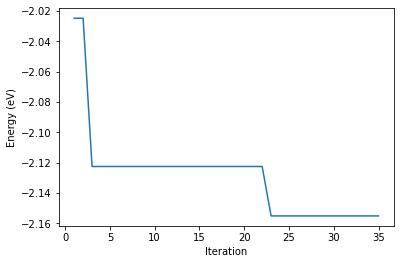

In [189]:
XX = [0]
YY = []

Ansatz = ansatz(N)

Gradient = 100

eps = 1

Ansatz.rx(noms_p[0],1)

parameters = np.array([0])

while Gradient >= eps :
    
    l = gradient(Ansatz, hamil) #list of [operator, meanvalue]
    
    Nop = Next_op(l , eps)
    
    if Nop[0]:
        
        "Gradient assez faible pour la convergence."
        
        opt_parameters = parameters
        
        break 
        
    Ansatz = grow_ansatz(Ansatz, Nop[1][0], parameters)
    
    np.append(parameters,noms_p[len(parameters)])
    
    vqe = VQE(Ansatz, optimizer=slsqp, quantum_instance=qi)
    
    result = vqe.compute_minimum_eigenvalue(operator= PrimitiveOp(Operator(hamil)))
    print('energie :' + str(result.eigenvalue))
    
    XX.append(XX[-1] + 1)
    
    YY.append(result.eigenvalue.real)
    
    parameters = result.optimal_point

print(Ansatz.parameters)

print(parameters[1::])

del XX[0]


plt.plot(XX, YY)

plt.xlabel("Iteration")
plt.ylabel("Energy (eV)")

plt.show()


##### 

In [139]:
print(Ansatz)

     ┌─────────────┐               ┌───┐               ┌───┐     »
q_0: ┤ Rx(0.03938) ├───────────────┤ X ├───────────────┤ X ├─────»
     ├─────────────┤┌─────────────┐└─┬─┘               └─┬─┘     »
q_1: ┤ Rx(0.27128) ├┤ Rx(theta_0) ├──┼───────────────────┼───────»
     └┬────────────┤└─────────────┘  │  ┌─────────────┐  │       »
q_2: ─┤ Rx(4.3296) ├─────────────────■──┤ Rz(theta_1) ├──■────■──»
      ├───────────┬┘                    └─────────────┘     ┌─┴─┐»
q_3: ─┤ Rx(1.062) ├─────────────────────────────────────────┤ X ├»
      └───────────┘                                         └───┘»
«                                                                 »
«q_0: ────────────────────────────────────────────────────────────»
«                              ┌───┐                    ┌───┐     »
«q_1: ─────────────────────────┤ X ├────────────────────┤ X ├──■──»
«     ┌─────────────┐          └─┬─┘     ┌─────────────┐└─┬─┘┌─┴─┐»
«q_2: ┤ Rz(theta_2) ├──■─────────■───────┤ Rz(theta_3) ├─

In [99]:
qc_1 = ansatz(4)
qc_1.rx(noms_p[0],1)
qc_1.rx(noms_p[1],0)
op_1 = trans(X,4,1)
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * X ^ I) + \
        (-0.01128010425623538 * X ^ Z) + \
        (0.18093119978423156 * X ^ X)
o_2 = commutator(hamil,op_1)

In [100]:
vqe = VQE(qc_1, optimizer=slsqp, quantum_instance=qi)
f = vqe.get_energy_evaluation(operator= PrimitiveOp(Operator(o_2)))

In [40]:
def measure_energy(qc, operator): 
    psi = CircuitStateFn(qc)
    return(psi.adjoint().compose(op).compose(psi).eval().real)

In [41]:
f(np.array([0.01,0.3]))

NameError: name 'f' is not defined

In [265]:
N = 4



operator = trans(CX, N, k[1][0]).permute(perm(k[1])).compose(trans(Z,N,k[1][0])).compose(trans(CX, N, k[1][0]))

In [8]:
print(o_2)

SummedOp([
  ComposedOp([
    TensoredOp([
      SummedOp([
        -1.0 *           ┌────────────┐     
        q_0: ──■──┤0           ├──■──
             ┌─┴─┐│  Pauli(ZI) │┌─┴─┐
        q_1: ┤ X ├┤1           ├┤ X ├
             └───┘└────────────┘└───┘,
        -3.0 * XI
      ]),
      II
    ]),
    IIYI
  ]),
  ComposedOp([
    TensoredOp([
      I,
      SummedOp([
        -1.0 *           ┌────────────┐     
        q_0: ──■──┤0           ├──■──
             ┌─┴─┐│  Pauli(ZI) │┌─┴─┐
        q_1: ┤ X ├┤1           ├┤ X ├
             └───┘└────────────┘└───┘,
        -3.0 * XI
      ]),
      I
    ]),
    IIYI
  ]),
  ComposedOp([
    TensoredOp([
      II,
      SummedOp([
        -1.0 *           ┌────────────┐     
        q_0: ──■──┤0           ├──■──
             ┌─┴─┐│  Pauli(ZI) │┌─┴─┐
        q_1: ┤ X ├┤1           ├┤ X ├
             └───┘└────────────┘└───┘,
        -3.0 * XI
      ])
    ]),
    IIYI
  ]),
  -1.0 * ComposedOp([
    IIYI,
    TensoredOp([
      Summe

In [102]:
qc = ansatz(4)
qc.rx(noms_p[0],1)

In [103]:


seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

slsqp = SLSQP(maxiter=1000)

vqe = VQE(qc, optimizer=slsqp, quantum_instance=qi)

result = vqe.compute_minimum_eigenvalue(operator= PrimitiveOp(Operator(hamil)))

print(result)
optimizer_evals = result.optimizer_evals


{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 8,
    'eigenstate': array([-3.88615175e-01+4.75916331e-17j, -1.95665934e-17-1.59773360e-01j,
       -7.57189578e-20-4.12194808e-04j,  1.69467776e-04-3.11307254e-20j,
        8.65416009e-17+7.06665799e-01j, -2.90535152e-01+3.55802945e-17j,
       -7.49543486e-04+1.37688905e-19j, -5.66087491e-20-3.08163677e-04j,
       -2.67194558e-17-2.18180914e-01j,  8.97018438e-02-1.09853076e-17j,
        2.31419269e-04-4.25110301e-20j,  1.74777789e-20+9.51445971e-05j,
       -3.96744645e-01+4.85872060e-17j, -1.99759085e-17-1.63115671e-01j,
       -7.73029284e-20-4.20817542e-04j,  1.73012885e-04-3.17819514e-20j]),
    'eigenvalue': (0.10366021454148634+0j),
    'optimal_circuit': None,
    'optimal_parameters': {Parameter(theta_0): 3.1087141919225263},
    'optimal_point': array([3.10871419]),
    'optimal_value': 0.10366021454148634,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.02368783950805664}


In [29]:
result.optimal_point

array([1.7536914 , 4.19301165])

In [154]:
qc = qc.bind_parameters(result.optimal_parameters)

In [155]:
qc.draw()

┌───────────┐                         
q_0: ┤ Rx(1.023) ├─────────────────────────
     ├───────────┤ ┌──────────────────────┐
q_1: ┤ Rx(5.367) ├─┤ Rx(4.05756505494093) ├
     ├───────────┴┐└──────────────────────┘
q_2: ┤ Rx(2.1944) ├────────────────────────
     ├────────────┤                        
q_3: ┤ Rx(4.4622) ├────────────────────────
     └────────────┘